## 進階機器學習 HW5-3-1

* 學號: B103040047
* 姓名: 周安

In [1]:
!pip install tqdm torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import pandas as pd
import os
import random

# for reproduce rsult
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    generator = torch.Generator().manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    return generator
generator = same_seeds(122)

# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

Train on cuda.


Use WGAN to learn and replicate the data distribution.

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.04)   # 權重初始化為 N(0, 0.04)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)       # bias 初始為 0
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.04)
        nn.init.constant_(m.bias.data, 0)

"""
torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)
"""
class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, out_dim)
    in_dim: distribution dim
    dim: hidden space's dim
    """
    def __init__(self, in_dim, out_dim, dim=64):
        super(Generator, self).__init__()
        self.lin = nn.Sequential(
            nn.Linear(in_dim, dim),
            nn.ReLU(),
            nn.Linear(dim, out_dim),
            nn.Tanh(), # [-1, 1]
            # nn.LeakyReLU(0.5),
        )
        self.apply(weights_init)
    def forward(self, x):
        x = 7 * self.lin(x) + 2 # [-1, 1] -> [-5, 9]
        return x
class Discriminator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, )
    in_dim: distribution dim
    dim: hidden space's dim
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        self.lin = nn.Sequential(
            nn.Linear(in_dim, dim),
            nn.ReLU(),
            nn.Linear(dim, 1),
            # nn.Sigmoid() # for BCELoss, WGAN don't need Sigmoid
        )
        self.apply(weights_init)
    def forward(self, x):
        x = self.lin(x)
        return x

## Initialization
* Create train dataset.
    * Two clusters with center (-3,-3) and (7,7)

torch.Size([100000, 2]) torch.Size([100000])


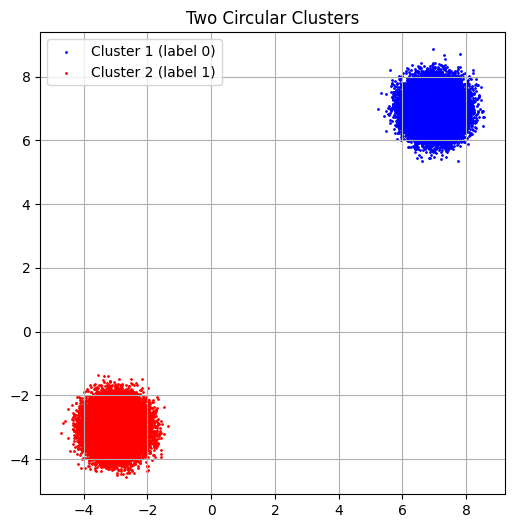

In [4]:
NUM_POINTS_PER_CLUSTER = 50000
BATCH_SIZE = 64
RANGE = 0.4
# Cluster 1: centered at (7, 7)
center_1 = np.array([7, 7])
radius_1 = RANGE  # Spread of the cluster
# Generate normally distributed points, scale by radius, and shift to center
points_1 = np.random.randn(NUM_POINTS_PER_CLUSTER, 2) * radius_1 + center_1

# Cluster 2: centered at (-3, -3)
center_2 = np.array([-3, -3])
radius_2 = RANGE
points_2 = np.random.randn(NUM_POINTS_PER_CLUSTER, 2) * radius_2 + center_2

# Combine both clusters into one dataset
X = np.vstack((points_1, points_2))
# Create corresponding labels: 0 for Cluster 1, 1 for Cluster 2
y = np.hstack((
    np.zeros(NUM_POINTS_PER_CLUSTER),
    np.ones(NUM_POINTS_PER_CLUSTER)
))

# create torch dateset and dataloader for training
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
print(X_tensor.shape, y_tensor.shape)

dot_dataset = TensorDataset(X_tensor, y_tensor)
dot_dataloader = DataLoader(dot_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Plot the dataset to visualize the two clusters
plt.figure(figsize=(6, 6))
plt.scatter(points_1[:, 0], points_1[:, 1], c='blue', label='Cluster 1 (label 0)', s=1)
plt.scatter(points_2[:, 0], points_2[:, 1], c='red', label='Cluster 2 (label 1)', s=1)
plt.legend()
plt.title('Two Circular Clusters')
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio for X and Y axes
plt.show()

In [5]:
for x, y in dot_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([64, 2]) torch.Size([64])


In [6]:
def draw_scatter(points):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(3, 3))

    # Plot the dataset
    ax.scatter(points[:, 0], points[:, 1], c='green', s=1)
    ax.set_title('Generated Distribution')
    ax.grid(True)
    ax.set_aspect('equal')  # Equal aspect ratio for X and Y axes

    # Set axis limits
    # ax.set_xlim(-10, 6)
    # ax.set_ylim(-10, 6)

    # Return the figure object for saving
    return fig

In [7]:
# Training hyperparameters
z_dim = 20 # Gemerator input dim
z_sample = Variable(torch.randn(10000, z_dim) * 1).to(device) # show some generated points during training
LR = 1e-4
hidden_dim=4096 # hidden dim in generator

NUM_EPOCHS = 200 # 50
n_critic = 2 # 5 # After train 5 steps discriminator, train generator once
clip_value = 0.01

log_dir = os.path.join("Training_Result", 'logs')
ckpt_dir = os.path.join("Training_Result", 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)


# Model
G = Generator(in_dim=z_dim, out_dim=2, dim=hidden_dim).to(device)
D = Discriminator(in_dim=2, dim=hidden_dim).to(device)
G.train()
D.train()

# Loss
criterion = nn.BCELoss()

# Optimizer
# opt_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
# opt_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
''' Use RMSprop for WGAN. '''
opt_D = torch.optim.RMSprop(D.parameters(), lr=LR)
opt_G = torch.optim.RMSprop(G.parameters(), lr=LR)

# See the model structure
summary(G, (1, z_dim))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 4096]                 86,016
│    └─ReLU: 2-2                         [1, 4096]                 --
│    └─Linear: 2-3                       [1, 2]                    8,194
│    └─Tanh: 2-4                         [1, 2]                    --
Total params: 94,210
Trainable params: 94,210
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.38
Estimated Total Size (MB): 0.41

In [8]:
summary(D, (1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 4096]                 12,288
│    └─ReLU: 2-2                         [1, 4096]                 --
│    └─Linear: 2-3                       [1, 1]                    4,097
Total params: 16,385
Trainable params: 16,385
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.07
Estimated Total Size (MB): 0.10

In [9]:
def plt_loss_accuracy_fig(Total_training_loss):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.title('Training loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
for param in D.parameters():
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


Initial generated result. (Before training)

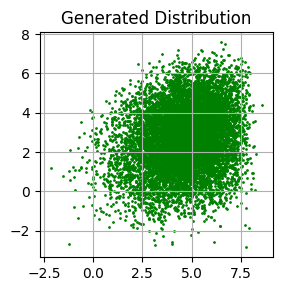

Generator(
  (lin): Sequential(
    (0): Linear(in_features=20, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=2, bias=True)
    (3): Tanh()
  )
)

In [11]:
G.eval()
f_points_sample = G(z_sample)
fig = draw_scatter(f_points_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)
G.train()

100%|██████████| 1563/1563 [00:06<00:00, 245.21it/s]


Epoch[ 1/200] : Generator Loss = 0.0320, Descriminator Loss = -0.0268


100%|██████████| 1563/1563 [00:13<00:00, 117.04it/s]


Epoch[ 2/200] : Generator Loss = 0.0532, Descriminator Loss = -0.0257


100%|██████████| 1563/1563 [00:07<00:00, 212.55it/s]


Epoch[ 3/200] : Generator Loss = 0.0410, Descriminator Loss = -0.0230


100%|██████████| 1563/1563 [00:05<00:00, 268.17it/s]


Epoch[ 4/200] : Generator Loss = 0.0290, Descriminator Loss = -0.0194


100%|██████████| 1563/1563 [00:06<00:00, 260.36it/s]


Epoch[ 5/200] : Generator Loss = 0.0119, Descriminator Loss = -0.0140


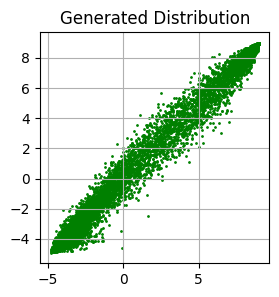

	| Save distribution image to Training_Result/logs/Epoch_005.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 239.53it/s]


Epoch[ 6/200] : Generator Loss = 0.0162, Descriminator Loss = -0.0063


100%|██████████| 1563/1563 [00:06<00:00, 247.70it/s]


Epoch[ 7/200] : Generator Loss = 0.0222, Descriminator Loss = -0.0046


100%|██████████| 1563/1563 [00:05<00:00, 265.65it/s]


Epoch[ 8/200] : Generator Loss = 0.0163, Descriminator Loss = -0.0034


100%|██████████| 1563/1563 [00:05<00:00, 260.78it/s]


Epoch[ 9/200] : Generator Loss = 0.0180, Descriminator Loss = -0.0030


100%|██████████| 1563/1563 [00:05<00:00, 262.39it/s]


Epoch[10/200] : Generator Loss = 0.0108, Descriminator Loss = -0.0026


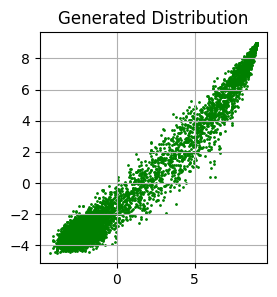

	| Save distribution image to Training_Result/logs/Epoch_010.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 261.71it/s]


Epoch[11/200] : Generator Loss = 0.0143, Descriminator Loss = -0.0018


100%|██████████| 1563/1563 [00:05<00:00, 265.65it/s]


Epoch[12/200] : Generator Loss = 0.0097, Descriminator Loss = -0.0019


100%|██████████| 1563/1563 [00:06<00:00, 259.93it/s]


Epoch[13/200] : Generator Loss = 0.0081, Descriminator Loss = -0.0019


100%|██████████| 1563/1563 [00:06<00:00, 227.23it/s]


Epoch[14/200] : Generator Loss = 0.0301, Descriminator Loss = -0.0021


100%|██████████| 1563/1563 [00:06<00:00, 239.43it/s]


Epoch[15/200] : Generator Loss = 0.0350, Descriminator Loss = -0.0028


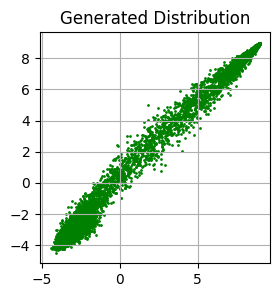

	| Save distribution image to Training_Result/logs/Epoch_015.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 254.49it/s]


Epoch[16/200] : Generator Loss = 0.0429, Descriminator Loss = -0.0024


100%|██████████| 1563/1563 [00:05<00:00, 275.49it/s]


Epoch[17/200] : Generator Loss = 0.0454, Descriminator Loss = -0.0030


100%|██████████| 1563/1563 [00:06<00:00, 257.53it/s]


Epoch[18/200] : Generator Loss = 0.0516, Descriminator Loss = -0.0032


100%|██████████| 1563/1563 [00:05<00:00, 268.84it/s]


Epoch[19/200] : Generator Loss = 0.0603, Descriminator Loss = -0.0036


100%|██████████| 1563/1563 [00:06<00:00, 258.47it/s]


Epoch[20/200] : Generator Loss = 0.0522, Descriminator Loss = -0.0036


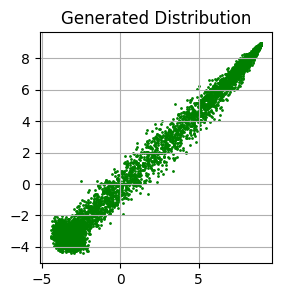

	| Save distribution image to Training_Result/logs/Epoch_020.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 270.16it/s]


Epoch[21/200] : Generator Loss = 0.0531, Descriminator Loss = -0.0036


100%|██████████| 1563/1563 [00:06<00:00, 256.42it/s]


Epoch[22/200] : Generator Loss = 0.0546, Descriminator Loss = -0.0035


100%|██████████| 1563/1563 [00:05<00:00, 266.45it/s]


Epoch[23/200] : Generator Loss = 0.0501, Descriminator Loss = -0.0037


100%|██████████| 1563/1563 [00:06<00:00, 257.53it/s]


Epoch[24/200] : Generator Loss = 0.0552, Descriminator Loss = -0.0036


100%|██████████| 1563/1563 [00:05<00:00, 265.94it/s]


Epoch[25/200] : Generator Loss = 0.0578, Descriminator Loss = -0.0036


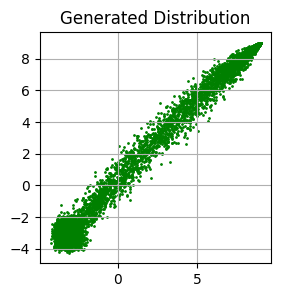

	| Save distribution image to Training_Result/logs/Epoch_025.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 256.84it/s]


Epoch[26/200] : Generator Loss = 0.0576, Descriminator Loss = -0.0038


100%|██████████| 1563/1563 [00:05<00:00, 266.78it/s]


Epoch[27/200] : Generator Loss = 0.0737, Descriminator Loss = -0.0051


100%|██████████| 1563/1563 [00:06<00:00, 256.83it/s]


Epoch[28/200] : Generator Loss = 0.0769, Descriminator Loss = -0.0045


100%|██████████| 1563/1563 [00:05<00:00, 265.76it/s]


Epoch[29/200] : Generator Loss = 0.0839, Descriminator Loss = -0.0047


100%|██████████| 1563/1563 [00:06<00:00, 255.15it/s]


Epoch[30/200] : Generator Loss = 0.0817, Descriminator Loss = -0.0046


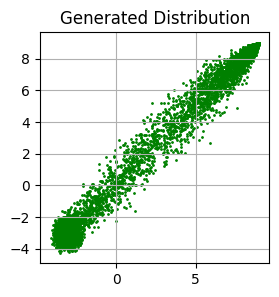

	| Save distribution image to Training_Result/logs/Epoch_030.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 267.10it/s]


Epoch[31/200] : Generator Loss = 0.0883, Descriminator Loss = -0.0046


100%|██████████| 1563/1563 [00:06<00:00, 253.58it/s]


Epoch[32/200] : Generator Loss = 0.0975, Descriminator Loss = -0.0054


100%|██████████| 1563/1563 [00:05<00:00, 264.26it/s]


Epoch[33/200] : Generator Loss = 0.1069, Descriminator Loss = -0.0062


100%|██████████| 1563/1563 [00:06<00:00, 252.07it/s]


Epoch[34/200] : Generator Loss = 0.1009, Descriminator Loss = -0.0055


100%|██████████| 1563/1563 [00:05<00:00, 264.22it/s]


Epoch[35/200] : Generator Loss = 0.0998, Descriminator Loss = -0.0056


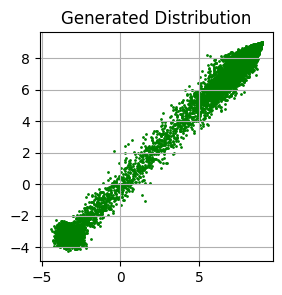

	| Save distribution image to Training_Result/logs/Epoch_035.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 252.86it/s]


Epoch[36/200] : Generator Loss = 0.0962, Descriminator Loss = -0.0047


100%|██████████| 1563/1563 [00:05<00:00, 270.26it/s]


Epoch[37/200] : Generator Loss = 0.0974, Descriminator Loss = -0.0040


100%|██████████| 1563/1563 [00:06<00:00, 256.43it/s]


Epoch[38/200] : Generator Loss = 0.0964, Descriminator Loss = -0.0042


100%|██████████| 1563/1563 [00:06<00:00, 260.43it/s]


Epoch[39/200] : Generator Loss = 0.1060, Descriminator Loss = -0.0034


100%|██████████| 1563/1563 [00:06<00:00, 249.33it/s]


Epoch[40/200] : Generator Loss = 0.0942, Descriminator Loss = -0.0034


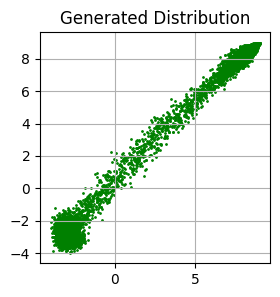

	| Save distribution image to Training_Result/logs/Epoch_040.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 270.91it/s]


Epoch[41/200] : Generator Loss = 0.0981, Descriminator Loss = -0.0034


100%|██████████| 1563/1563 [00:06<00:00, 250.45it/s]


Epoch[42/200] : Generator Loss = 0.1020, Descriminator Loss = -0.0033


100%|██████████| 1563/1563 [00:05<00:00, 268.25it/s]


Epoch[43/200] : Generator Loss = 0.1055, Descriminator Loss = -0.0023


100%|██████████| 1563/1563 [00:06<00:00, 250.70it/s]


Epoch[44/200] : Generator Loss = 0.1073, Descriminator Loss = -0.0024


100%|██████████| 1563/1563 [00:05<00:00, 267.33it/s]


Epoch[45/200] : Generator Loss = 0.1044, Descriminator Loss = -0.0025


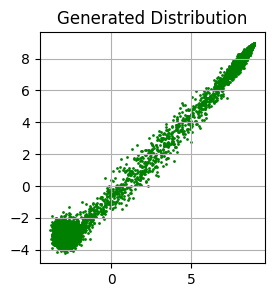

	| Save distribution image to Training_Result/logs/Epoch_045.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 249.03it/s]


Epoch[46/200] : Generator Loss = 0.1092, Descriminator Loss = -0.0023


100%|██████████| 1563/1563 [00:05<00:00, 268.59it/s]


Epoch[47/200] : Generator Loss = 0.1137, Descriminator Loss = -0.0022


100%|██████████| 1563/1563 [00:06<00:00, 248.31it/s]


Epoch[48/200] : Generator Loss = 0.1092, Descriminator Loss = -0.0021


100%|██████████| 1563/1563 [00:05<00:00, 267.10it/s]


Epoch[49/200] : Generator Loss = 0.1107, Descriminator Loss = -0.0024


100%|██████████| 1563/1563 [00:06<00:00, 248.03it/s]


Epoch[50/200] : Generator Loss = 0.1113, Descriminator Loss = -0.0022


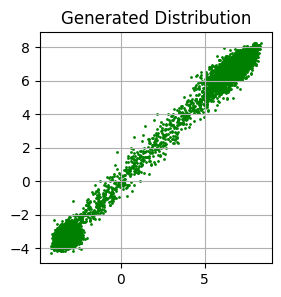

	| Save distribution image to Training_Result/logs/Epoch_050.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 267.76it/s]


Epoch[51/200] : Generator Loss = 0.1120, Descriminator Loss = -0.0023


100%|██████████| 1563/1563 [00:06<00:00, 248.72it/s]


Epoch[52/200] : Generator Loss = 0.1132, Descriminator Loss = -0.0021


100%|██████████| 1563/1563 [00:05<00:00, 269.05it/s]


Epoch[53/200] : Generator Loss = 0.1022, Descriminator Loss = -0.0023


100%|██████████| 1563/1563 [00:06<00:00, 247.50it/s]


Epoch[54/200] : Generator Loss = 0.1131, Descriminator Loss = -0.0018


100%|██████████| 1563/1563 [00:05<00:00, 265.38it/s]


Epoch[55/200] : Generator Loss = 0.1132, Descriminator Loss = -0.0023


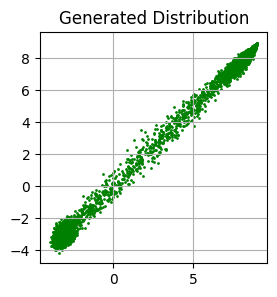

	| Save distribution image to Training_Result/logs/Epoch_055.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 250.57it/s]


Epoch[56/200] : Generator Loss = 0.1196, Descriminator Loss = -0.0017


100%|██████████| 1563/1563 [00:05<00:00, 271.07it/s]


Epoch[57/200] : Generator Loss = 0.1221, Descriminator Loss = -0.0019


100%|██████████| 1563/1563 [00:06<00:00, 246.35it/s]


Epoch[58/200] : Generator Loss = 0.1129, Descriminator Loss = -0.0019


100%|██████████| 1563/1563 [00:05<00:00, 269.94it/s]


Epoch[59/200] : Generator Loss = 0.1106, Descriminator Loss = -0.0016


100%|██████████| 1563/1563 [00:06<00:00, 245.21it/s]


Epoch[60/200] : Generator Loss = 0.1134, Descriminator Loss = -0.0022


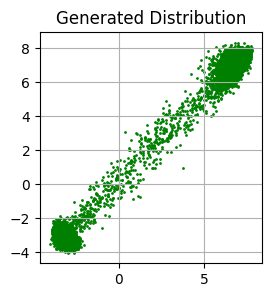

	| Save distribution image to Training_Result/logs/Epoch_060.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 268.04it/s]


Epoch[61/200] : Generator Loss = 0.1120, Descriminator Loss = -0.0016


100%|██████████| 1563/1563 [00:06<00:00, 247.64it/s]


Epoch[62/200] : Generator Loss = 0.1141, Descriminator Loss = -0.0018


100%|██████████| 1563/1563 [00:05<00:00, 267.10it/s]


Epoch[63/200] : Generator Loss = 0.1114, Descriminator Loss = -0.0017


100%|██████████| 1563/1563 [00:06<00:00, 246.36it/s]


Epoch[64/200] : Generator Loss = 0.1102, Descriminator Loss = -0.0019


100%|██████████| 1563/1563 [00:05<00:00, 269.98it/s]


Epoch[65/200] : Generator Loss = 0.1098, Descriminator Loss = -0.0017


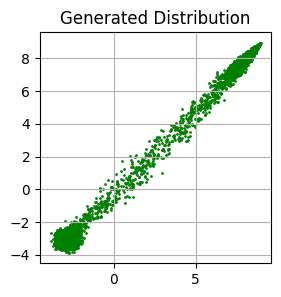

	| Save distribution image to Training_Result/logs/Epoch_065.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 247.72it/s]


Epoch[66/200] : Generator Loss = 0.1133, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:05<00:00, 269.14it/s]


Epoch[67/200] : Generator Loss = 0.1096, Descriminator Loss = -0.0022


100%|██████████| 1563/1563 [00:06<00:00, 243.48it/s]


Epoch[68/200] : Generator Loss = 0.1116, Descriminator Loss = -0.0017


100%|██████████| 1563/1563 [00:05<00:00, 267.94it/s]


Epoch[69/200] : Generator Loss = 0.1012, Descriminator Loss = -0.0015


100%|██████████| 1563/1563 [00:06<00:00, 246.82it/s]


Epoch[70/200] : Generator Loss = 0.0919, Descriminator Loss = -0.0010


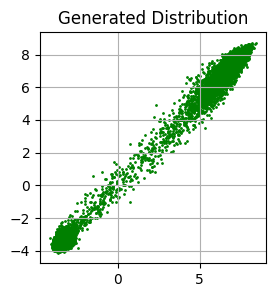

	| Save distribution image to Training_Result/logs/Epoch_070.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 266.51it/s]


Epoch[71/200] : Generator Loss = 0.0928, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 245.83it/s]


Epoch[72/200] : Generator Loss = 0.1010, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:05<00:00, 263.16it/s]


Epoch[73/200] : Generator Loss = 0.0887, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 243.12it/s]


Epoch[74/200] : Generator Loss = 0.0884, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:05<00:00, 267.38it/s]


Epoch[75/200] : Generator Loss = 0.0852, Descriminator Loss = -0.0010


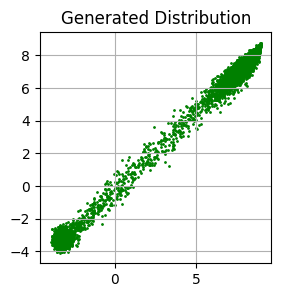

	| Save distribution image to Training_Result/logs/Epoch_075.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 249.60it/s]


Epoch[76/200] : Generator Loss = 0.0790, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:05<00:00, 269.31it/s]


Epoch[77/200] : Generator Loss = 0.0802, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 246.95it/s]


Epoch[78/200] : Generator Loss = 0.0741, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:05<00:00, 267.22it/s]


Epoch[79/200] : Generator Loss = 0.0725, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:06<00:00, 246.67it/s]


Epoch[80/200] : Generator Loss = 0.0767, Descriminator Loss = -0.0007


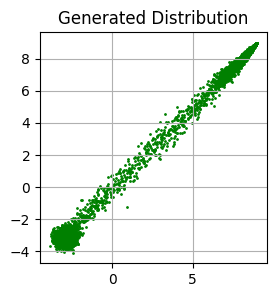

	| Save distribution image to Training_Result/logs/Epoch_080.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 265.84it/s]


Epoch[81/200] : Generator Loss = 0.0768, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 244.90it/s]


Epoch[82/200] : Generator Loss = 0.0752, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:05<00:00, 264.44it/s]


Epoch[83/200] : Generator Loss = 0.0793, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:06<00:00, 245.83it/s]


Epoch[84/200] : Generator Loss = 0.0865, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:05<00:00, 263.61it/s]


Epoch[85/200] : Generator Loss = 0.0977, Descriminator Loss = -0.0012


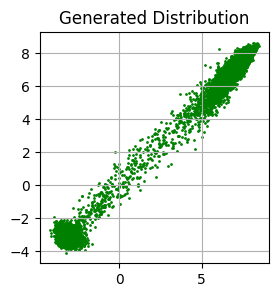

	| Save distribution image to Training_Result/logs/Epoch_085.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 244.20it/s]


Epoch[86/200] : Generator Loss = 0.1159, Descriminator Loss = -0.0017


100%|██████████| 1563/1563 [00:05<00:00, 266.91it/s]


Epoch[87/200] : Generator Loss = 0.1125, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:06<00:00, 246.92it/s]


Epoch[88/200] : Generator Loss = 0.1100, Descriminator Loss = -0.0019


100%|██████████| 1563/1563 [00:06<00:00, 260.01it/s]


Epoch[89/200] : Generator Loss = 0.1221, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 242.30it/s]


Epoch[90/200] : Generator Loss = 0.1196, Descriminator Loss = -0.0014


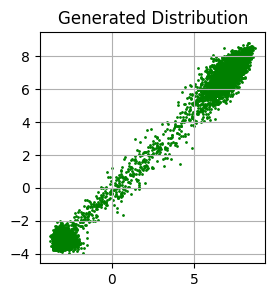

	| Save distribution image to Training_Result/logs/Epoch_090.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 265.25it/s]


Epoch[91/200] : Generator Loss = 0.1119, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:06<00:00, 244.26it/s]


Epoch[92/200] : Generator Loss = 0.1121, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:05<00:00, 264.60it/s]


Epoch[93/200] : Generator Loss = 0.1043, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 243.77it/s]


Epoch[94/200] : Generator Loss = 0.1210, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:05<00:00, 265.50it/s]


Epoch[95/200] : Generator Loss = 0.1125, Descriminator Loss = -0.0013


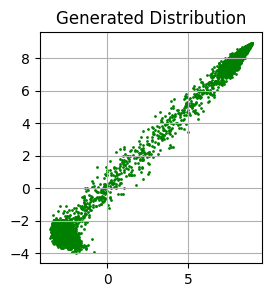

	| Save distribution image to Training_Result/logs/Epoch_095.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 248.70it/s]


Epoch[96/200] : Generator Loss = 0.1135, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:05<00:00, 266.89it/s]


Epoch[97/200] : Generator Loss = 0.1029, Descriminator Loss = -0.0015


100%|██████████| 1563/1563 [00:06<00:00, 244.95it/s]


Epoch[98/200] : Generator Loss = 0.1007, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:05<00:00, 262.71it/s]


Epoch[99/200] : Generator Loss = 0.1067, Descriminator Loss = -0.0015


100%|██████████| 1563/1563 [00:06<00:00, 241.55it/s]


Epoch[100/200] : Generator Loss = 0.1029, Descriminator Loss = -0.0012


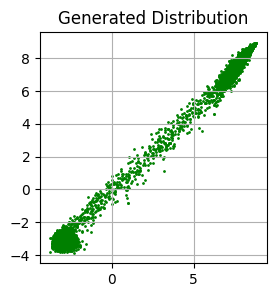

	| Save distribution image to Training_Result/logs/Epoch_100.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 262.03it/s]


Epoch[101/200] : Generator Loss = 0.0986, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 249.89it/s]


Epoch[102/200] : Generator Loss = 0.1062, Descriminator Loss = -0.0015


100%|██████████| 1563/1563 [00:06<00:00, 259.50it/s]


Epoch[103/200] : Generator Loss = 0.0980, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 248.44it/s]


Epoch[104/200] : Generator Loss = 0.0974, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 258.45it/s]


Epoch[105/200] : Generator Loss = 0.1034, Descriminator Loss = -0.0006


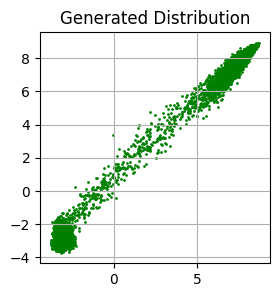

	| Save distribution image to Training_Result/logs/Epoch_105.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 252.60it/s]


Epoch[106/200] : Generator Loss = 0.1023, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 258.48it/s]


Epoch[107/200] : Generator Loss = 0.0926, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 254.37it/s]


Epoch[108/200] : Generator Loss = 0.1009, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 256.07it/s]


Epoch[109/200] : Generator Loss = 0.1057, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 254.52it/s]


Epoch[110/200] : Generator Loss = 0.1136, Descriminator Loss = -0.0016


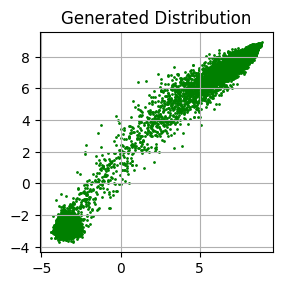

	| Save distribution image to Training_Result/logs/Epoch_110.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 252.51it/s]


Epoch[111/200] : Generator Loss = 0.1083, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 254.18it/s]


Epoch[112/200] : Generator Loss = 0.1029, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 248.72it/s]


Epoch[113/200] : Generator Loss = 0.1131, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 258.89it/s]


Epoch[114/200] : Generator Loss = 0.1069, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 249.26it/s]


Epoch[115/200] : Generator Loss = 0.1061, Descriminator Loss = -0.0010


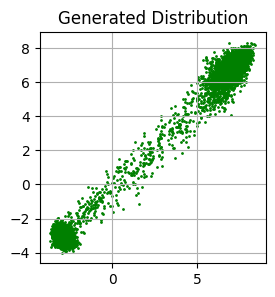

	| Save distribution image to Training_Result/logs/Epoch_115.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 261.35it/s]


Epoch[116/200] : Generator Loss = 0.1024, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 245.60it/s]


Epoch[117/200] : Generator Loss = 0.1107, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:05<00:00, 262.16it/s]


Epoch[118/200] : Generator Loss = 0.1248, Descriminator Loss = -0.0016


100%|██████████| 1563/1563 [00:06<00:00, 245.59it/s]


Epoch[119/200] : Generator Loss = 0.1301, Descriminator Loss = -0.0015


100%|██████████| 1563/1563 [00:05<00:00, 263.15it/s]


Epoch[120/200] : Generator Loss = 0.1240, Descriminator Loss = -0.0014


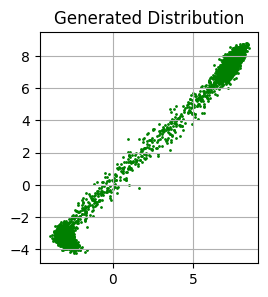

	| Save distribution image to Training_Result/logs/Epoch_120.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 240.93it/s]


Epoch[121/200] : Generator Loss = 0.1269, Descriminator Loss = -0.0015


100%|██████████| 1563/1563 [00:05<00:00, 263.41it/s]


Epoch[122/200] : Generator Loss = 0.1277, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 244.05it/s]


Epoch[123/200] : Generator Loss = 0.1211, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:05<00:00, 263.95it/s]


Epoch[124/200] : Generator Loss = 0.1001, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 246.13it/s]


Epoch[125/200] : Generator Loss = 0.0947, Descriminator Loss = -0.0010


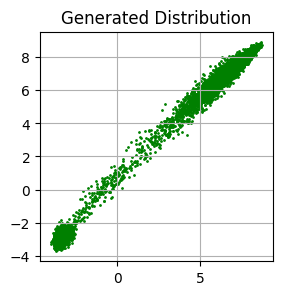

	| Save distribution image to Training_Result/logs/Epoch_125.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 262.24it/s]


Epoch[126/200] : Generator Loss = 0.0932, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 243.70it/s]


Epoch[127/200] : Generator Loss = 0.0819, Descriminator Loss = -0.0002


100%|██████████| 1563/1563 [00:05<00:00, 262.36it/s]


Epoch[128/200] : Generator Loss = 0.0735, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:06<00:00, 245.19it/s]


Epoch[129/200] : Generator Loss = 0.0771, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:05<00:00, 265.92it/s]


Epoch[130/200] : Generator Loss = 0.0807, Descriminator Loss = -0.0006


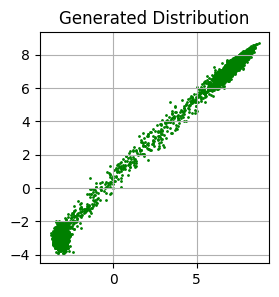

	| Save distribution image to Training_Result/logs/Epoch_130.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 239.50it/s]


Epoch[131/200] : Generator Loss = 0.0835, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:05<00:00, 263.41it/s]


Epoch[132/200] : Generator Loss = 0.0817, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:06<00:00, 241.63it/s]


Epoch[133/200] : Generator Loss = 0.0759, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:05<00:00, 263.87it/s]


Epoch[134/200] : Generator Loss = 0.0834, Descriminator Loss = -0.0005


100%|██████████| 1563/1563 [00:06<00:00, 243.65it/s]


Epoch[135/200] : Generator Loss = 0.0855, Descriminator Loss = -0.0011


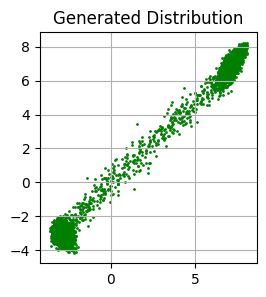

	| Save distribution image to Training_Result/logs/Epoch_135.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 262.53it/s]


Epoch[136/200] : Generator Loss = 0.0863, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 239.64it/s]


Epoch[137/200] : Generator Loss = 0.0946, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:05<00:00, 261.70it/s]


Epoch[138/200] : Generator Loss = 0.0991, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 240.01it/s]


Epoch[139/200] : Generator Loss = 0.1054, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 258.65it/s]


Epoch[140/200] : Generator Loss = 0.1092, Descriminator Loss = -0.0008


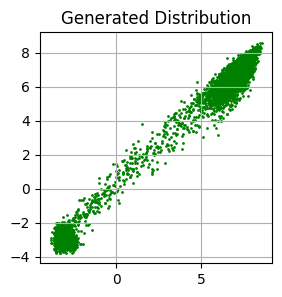

	| Save distribution image to Training_Result/logs/Epoch_140.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 240.80it/s]


Epoch[141/200] : Generator Loss = 0.0966, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:05<00:00, 261.87it/s]


Epoch[142/200] : Generator Loss = 0.0956, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 240.51it/s]


Epoch[143/200] : Generator Loss = 0.1091, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:05<00:00, 266.33it/s]


Epoch[144/200] : Generator Loss = 0.1057, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 242.08it/s]


Epoch[145/200] : Generator Loss = 0.1037, Descriminator Loss = -0.0012


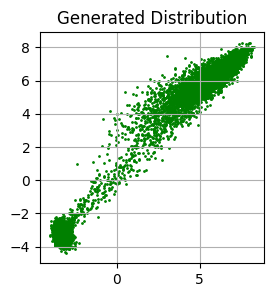

	| Save distribution image to Training_Result/logs/Epoch_145.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 262.72it/s]


Epoch[146/200] : Generator Loss = 0.1074, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:06<00:00, 238.51it/s]


Epoch[147/200] : Generator Loss = 0.1142, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:06<00:00, 257.67it/s]


Epoch[148/200] : Generator Loss = 0.1194, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 244.88it/s]


Epoch[149/200] : Generator Loss = 0.1229, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 256.58it/s]


Epoch[150/200] : Generator Loss = 0.1308, Descriminator Loss = -0.0014


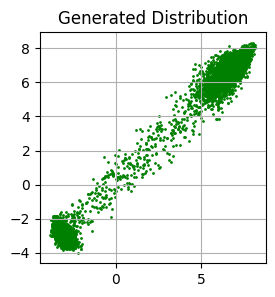

	| Save distribution image to Training_Result/logs/Epoch_150.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 245.88it/s]


Epoch[151/200] : Generator Loss = 0.1256, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:06<00:00, 248.14it/s]


Epoch[152/200] : Generator Loss = 0.1276, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 248.43it/s]


Epoch[153/200] : Generator Loss = 0.1324, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:06<00:00, 250.07it/s]


Epoch[154/200] : Generator Loss = 0.1237, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 254.81it/s]


Epoch[155/200] : Generator Loss = 0.1284, Descriminator Loss = -0.0012


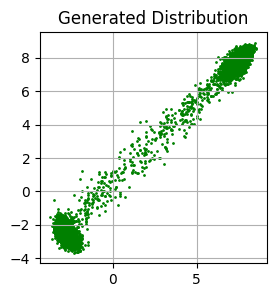

	| Save distribution image to Training_Result/logs/Epoch_155.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 246.30it/s]


Epoch[156/200] : Generator Loss = 0.1300, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:06<00:00, 252.27it/s]


Epoch[157/200] : Generator Loss = 0.1340, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:06<00:00, 240.48it/s]


Epoch[158/200] : Generator Loss = 0.1267, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 258.95it/s]


Epoch[159/200] : Generator Loss = 0.1328, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 240.39it/s]


Epoch[160/200] : Generator Loss = 0.1290, Descriminator Loss = -0.0009


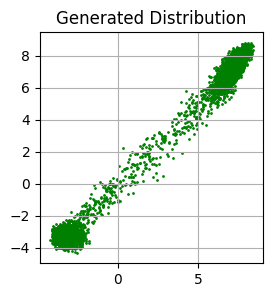

	| Save distribution image to Training_Result/logs/Epoch_160.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 260.45it/s]


Epoch[161/200] : Generator Loss = 0.1342, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 241.36it/s]


Epoch[162/200] : Generator Loss = 0.1301, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:05<00:00, 261.86it/s]


Epoch[163/200] : Generator Loss = 0.1293, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 242.04it/s]


Epoch[164/200] : Generator Loss = 0.1340, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:05<00:00, 261.42it/s]


Epoch[165/200] : Generator Loss = 0.1380, Descriminator Loss = -0.0013


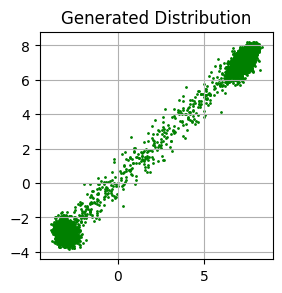

	| Save distribution image to Training_Result/logs/Epoch_165.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 238.37it/s]


Epoch[166/200] : Generator Loss = 0.1349, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:05<00:00, 264.17it/s]


Epoch[167/200] : Generator Loss = 0.1310, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:06<00:00, 241.13it/s]


Epoch[168/200] : Generator Loss = 0.1317, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:05<00:00, 261.78it/s]


Epoch[169/200] : Generator Loss = 0.1325, Descriminator Loss = -0.0013


100%|██████████| 1563/1563 [00:06<00:00, 237.78it/s]


Epoch[170/200] : Generator Loss = 0.1328, Descriminator Loss = -0.0010


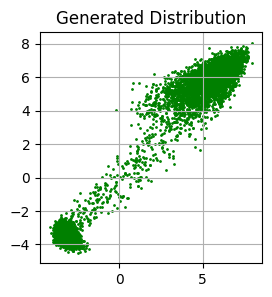

	| Save distribution image to Training_Result/logs/Epoch_170.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 259.03it/s]


Epoch[171/200] : Generator Loss = 0.1388, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 239.59it/s]


Epoch[172/200] : Generator Loss = 0.1336, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 259.67it/s]


Epoch[173/200] : Generator Loss = 0.1364, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 240.99it/s]


Epoch[174/200] : Generator Loss = 0.1386, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:05<00:00, 261.05it/s]


Epoch[175/200] : Generator Loss = 0.1358, Descriminator Loss = -0.0010


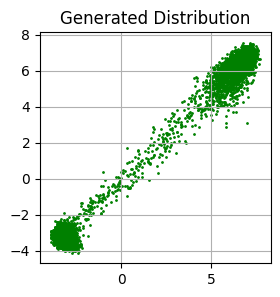

	| Save distribution image to Training_Result/logs/Epoch_175.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 238.75it/s]


Epoch[176/200] : Generator Loss = 0.1311, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:05<00:00, 260.93it/s]


Epoch[177/200] : Generator Loss = 0.1342, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:06<00:00, 241.61it/s]


Epoch[178/200] : Generator Loss = 0.1306, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:05<00:00, 261.06it/s]


Epoch[179/200] : Generator Loss = 0.1320, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 238.79it/s]


Epoch[180/200] : Generator Loss = 0.1347, Descriminator Loss = -0.0008


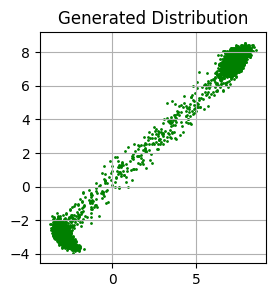

	| Save distribution image to Training_Result/logs/Epoch_180.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 258.12it/s]


Epoch[181/200] : Generator Loss = 0.1253, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 239.84it/s]


Epoch[182/200] : Generator Loss = 0.1301, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 259.96it/s]


Epoch[183/200] : Generator Loss = 0.1350, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 237.05it/s]


Epoch[184/200] : Generator Loss = 0.1366, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 257.13it/s]


Epoch[185/200] : Generator Loss = 0.1355, Descriminator Loss = -0.0010


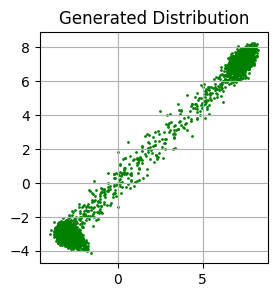

	| Save distribution image to Training_Result/logs/Epoch_185.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 241.42it/s]


Epoch[186/200] : Generator Loss = 0.1324, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 256.19it/s]


Epoch[187/200] : Generator Loss = 0.1372, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:06<00:00, 239.36it/s]


Epoch[188/200] : Generator Loss = 0.1348, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 244.10it/s]


Epoch[189/200] : Generator Loss = 0.1320, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 245.69it/s]


Epoch[190/200] : Generator Loss = 0.1350, Descriminator Loss = -0.0010


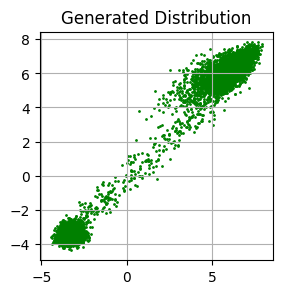

	| Save distribution image to Training_Result/logs/Epoch_190.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 250.19it/s]


Epoch[191/200] : Generator Loss = 0.1335, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 253.38it/s]


Epoch[192/200] : Generator Loss = 0.1401, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 244.00it/s]


Epoch[193/200] : Generator Loss = 0.1309, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 253.87it/s]


Epoch[194/200] : Generator Loss = 0.1359, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 236.62it/s]


Epoch[195/200] : Generator Loss = 0.1339, Descriminator Loss = -0.0008


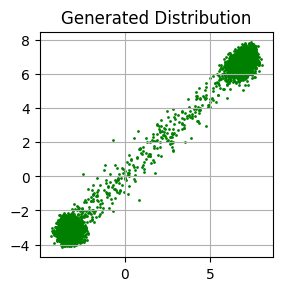

	| Save distribution image to Training_Result/logs/Epoch_195.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 260.68it/s]


Epoch[196/200] : Generator Loss = 0.1382, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 239.86it/s]


Epoch[197/200] : Generator Loss = 0.1300, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:05<00:00, 260.77it/s]


Epoch[198/200] : Generator Loss = 0.1354, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 239.97it/s]


Epoch[199/200] : Generator Loss = 0.1327, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:05<00:00, 260.50it/s]


Epoch[200/200] : Generator Loss = 0.1318, Descriminator Loss = -0.0005


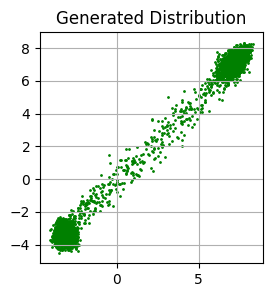

	| Save distribution image to Training_Result/logs/Epoch_200.jpg.


In [12]:
from tqdm import tqdm

# Start training and testing
best_loss = 100
# For ploting the trend image
total_train_loss_G = list()
total_train_loss_D = list()
for epoc in range(NUM_EPOCHS):
    train_loss_G = list()
    train_loss_D = list()
    progress_bar = tqdm(dot_dataloader)
    for i, (x, _) in enumerate(progress_bar):
        ''' train D '''
        r_point = x.to(device)
        # random noise
        z = Variable(torch.randn(x.shape[0], z_dim)).to(device)

        f_point = G(z) # output shape is (batch_size, 2)
        # prepare value for loss function
        r_label = Variable(torch.ones(x.shape[0], 1)).to(device) # real: 1
        f_label = Variable(torch.zeros(x.shape[0], 1)).to(device) # fake: 0

        # Forward D
        # r_logit = D(r_point.detach())
        # f_logit = D(f_point.detach())

        # GAN Loss
        # r_loss = criterion(r_logit, r_label)
        # f_loss = criterion(f_logit, f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(D(r_point)) + torch.mean(D(f_point))

        # Model backwarding
        opt_D.zero_grad()
        loss_D.backward()

        # Update the descriminator.
        opt_D.step()

        train_loss_D.append(loss_D.item())

        """ Clip weights of discriminator. """
        for p in D.parameters():
           p.data.clamp_(-clip_value, clip_value)

        ''' train G '''
        if i % n_critic == 0:
            # random noise
            z = Variable(torch.randn(x.shape[0], z_dim)).to(device)

            f_point = G(z) # output shape is (batch_size, 2)

            # f_logit = D(f_point)
            # GAN Loss
            # loss_G = criterion(f_logit, r_label)

            # WGAN Loss
            loss_G = -torch.mean(D(f_point))

            # Model backwarding
            opt_G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

            train_loss_G.append(loss_G.item())

    mean_loss_D = np.mean(train_loss_D)
    mean_loss_G = np.mean(train_loss_G)
    # record the training data
    total_train_loss_D.append(mean_loss_D)
    total_train_loss_G.append(mean_loss_G)
    print("Epoch[{:>2d}/{:>2d}] : Generator Loss = {:.4f}, Descriminator Loss = {:.4f}".format(epoc+1, NUM_EPOCHS, mean_loss_G, mean_loss_D))

    if (epoc+1) % 5 == 0:
        G.eval()
        f_points_sample = G(z_sample)
        fig = draw_scatter(f_points_sample.cpu().detach().numpy())
        filename = os.path.join(log_dir, f'Epoch_{epoc+1:03d}.jpg')
        fig.savefig(filename, dpi=300)
        plt.show()
        plt.close(fig)
        print(f'\t| Save distribution image to {filename}.')

        G.train()
    # Save the checkpoints.
    torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))
    torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))

Train 100 more epochs!

100%|██████████| 1563/1563 [00:06<00:00, 253.20it/s]


Epoch[201/300] : Generator Loss = 0.1351, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 244.92it/s]


Epoch[202/300] : Generator Loss = 0.1344, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 252.50it/s]


Epoch[203/300] : Generator Loss = 0.1345, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:05<00:00, 262.51it/s]


Epoch[204/300] : Generator Loss = 0.1337, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:07<00:00, 223.11it/s]


Epoch[205/300] : Generator Loss = 0.1346, Descriminator Loss = -0.0007


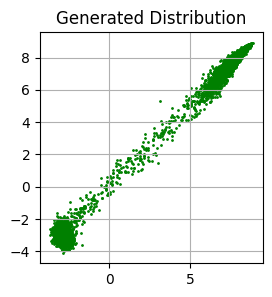

	| Save distribution image to Training_Result/logs/Epoch_205.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 253.57it/s]


Epoch[206/300] : Generator Loss = 0.1338, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 229.02it/s]


Epoch[207/300] : Generator Loss = 0.1380, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 257.13it/s]


Epoch[208/300] : Generator Loss = 0.1388, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 241.19it/s]


Epoch[209/300] : Generator Loss = 0.1367, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:05<00:00, 264.73it/s]


Epoch[210/300] : Generator Loss = 0.1400, Descriminator Loss = -0.0007


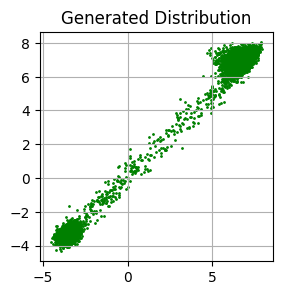

	| Save distribution image to Training_Result/logs/Epoch_210.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 245.44it/s]


Epoch[211/300] : Generator Loss = 0.1382, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:05<00:00, 261.67it/s]


Epoch[212/300] : Generator Loss = 0.1401, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 243.00it/s]


Epoch[213/300] : Generator Loss = 0.1417, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:05<00:00, 264.28it/s]


Epoch[214/300] : Generator Loss = 0.1411, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:06<00:00, 228.44it/s]


Epoch[215/300] : Generator Loss = 0.1372, Descriminator Loss = -0.0006


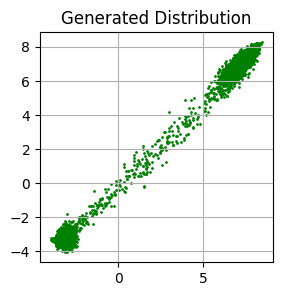

	| Save distribution image to Training_Result/logs/Epoch_215.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 263.06it/s]


Epoch[216/300] : Generator Loss = 0.1394, Descriminator Loss = -0.0005


100%|██████████| 1563/1563 [00:06<00:00, 243.45it/s]


Epoch[217/300] : Generator Loss = 0.1390, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:05<00:00, 262.08it/s]


Epoch[218/300] : Generator Loss = 0.1357, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 239.27it/s]


Epoch[219/300] : Generator Loss = 0.1378, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 249.65it/s]


Epoch[220/300] : Generator Loss = 0.1405, Descriminator Loss = -0.0011


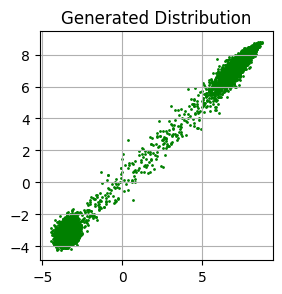

	| Save distribution image to Training_Result/logs/Epoch_220.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 242.22it/s]


Epoch[221/300] : Generator Loss = 0.1403, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:06<00:00, 251.70it/s]


Epoch[222/300] : Generator Loss = 0.1407, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 245.93it/s]


Epoch[223/300] : Generator Loss = 0.1368, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 239.94it/s]


Epoch[224/300] : Generator Loss = 0.1333, Descriminator Loss = -0.0015


100%|██████████| 1563/1563 [00:06<00:00, 249.58it/s]


Epoch[225/300] : Generator Loss = 0.1347, Descriminator Loss = -0.0014


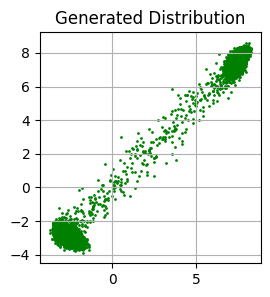

	| Save distribution image to Training_Result/logs/Epoch_225.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 239.81it/s]


Epoch[226/300] : Generator Loss = 0.1421, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:05<00:00, 260.81it/s]


Epoch[227/300] : Generator Loss = 0.1338, Descriminator Loss = -0.0005


100%|██████████| 1563/1563 [00:06<00:00, 241.32it/s]


Epoch[228/300] : Generator Loss = 0.1415, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 255.91it/s]


Epoch[229/300] : Generator Loss = 0.1403, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 240.00it/s]


Epoch[230/300] : Generator Loss = 0.1346, Descriminator Loss = -0.0009


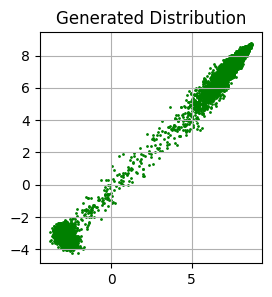

	| Save distribution image to Training_Result/logs/Epoch_230.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 258.76it/s]


Epoch[231/300] : Generator Loss = 0.1344, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 244.85it/s]


Epoch[232/300] : Generator Loss = 0.1395, Descriminator Loss = -0.0016


100%|██████████| 1563/1563 [00:06<00:00, 255.56it/s]


Epoch[233/300] : Generator Loss = 0.1378, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 235.99it/s]


Epoch[234/300] : Generator Loss = 0.1341, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 248.77it/s]


Epoch[235/300] : Generator Loss = 0.1317, Descriminator Loss = -0.0008


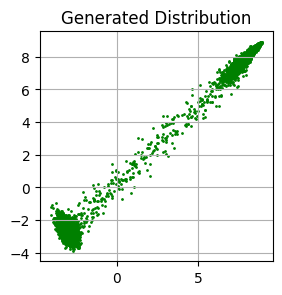

	| Save distribution image to Training_Result/logs/Epoch_235.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 238.78it/s]


Epoch[236/300] : Generator Loss = 0.1393, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 258.98it/s]


Epoch[237/300] : Generator Loss = 0.1340, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:06<00:00, 238.88it/s]


Epoch[238/300] : Generator Loss = 0.1310, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:06<00:00, 256.18it/s]


Epoch[239/300] : Generator Loss = 0.1353, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 239.72it/s]


Epoch[240/300] : Generator Loss = 0.1318, Descriminator Loss = -0.0005


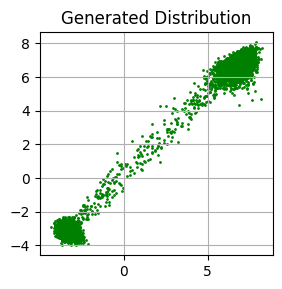

	| Save distribution image to Training_Result/logs/Epoch_240.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 250.23it/s]


Epoch[241/300] : Generator Loss = 0.1394, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 244.64it/s]


Epoch[242/300] : Generator Loss = 0.1343, Descriminator Loss = -0.0005


100%|██████████| 1563/1563 [00:06<00:00, 246.57it/s]


Epoch[243/300] : Generator Loss = 0.1394, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 249.96it/s]


Epoch[244/300] : Generator Loss = 0.1338, Descriminator Loss = -0.0002


100%|██████████| 1563/1563 [00:06<00:00, 244.55it/s]


Epoch[245/300] : Generator Loss = 0.1320, Descriminator Loss = -0.0014


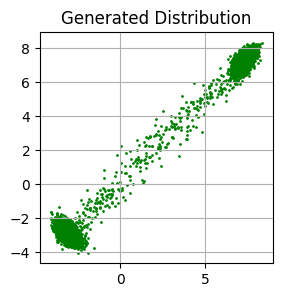

	| Save distribution image to Training_Result/logs/Epoch_245.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 256.53it/s]


Epoch[246/300] : Generator Loss = 0.1377, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 235.18it/s]


Epoch[247/300] : Generator Loss = 0.1337, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 259.62it/s]


Epoch[248/300] : Generator Loss = 0.1359, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 239.30it/s]


Epoch[249/300] : Generator Loss = 0.1407, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:05<00:00, 260.75it/s]


Epoch[250/300] : Generator Loss = 0.1376, Descriminator Loss = -0.0007


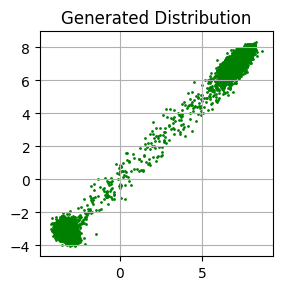

	| Save distribution image to Training_Result/logs/Epoch_250.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 244.55it/s]


Epoch[251/300] : Generator Loss = 0.1323, Descriminator Loss = -0.0003


100%|██████████| 1563/1563 [00:06<00:00, 258.03it/s]


Epoch[252/300] : Generator Loss = 0.1321, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 241.49it/s]


Epoch[253/300] : Generator Loss = 0.1306, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 256.80it/s]


Epoch[254/300] : Generator Loss = 0.1354, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 238.38it/s]


Epoch[255/300] : Generator Loss = 0.1336, Descriminator Loss = -0.0010


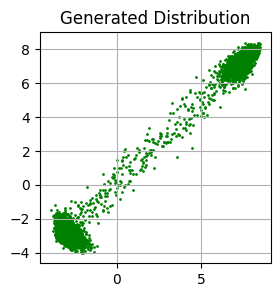

	| Save distribution image to Training_Result/logs/Epoch_255.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 257.34it/s]


Epoch[256/300] : Generator Loss = 0.1277, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 236.66it/s]


Epoch[257/300] : Generator Loss = 0.1361, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:06<00:00, 258.31it/s]


Epoch[258/300] : Generator Loss = 0.1323, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 235.69it/s]


Epoch[259/300] : Generator Loss = 0.1380, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 257.34it/s]


Epoch[260/300] : Generator Loss = 0.1339, Descriminator Loss = -0.0005


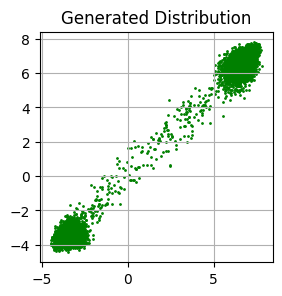

	| Save distribution image to Training_Result/logs/Epoch_260.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 235.17it/s]


Epoch[261/300] : Generator Loss = 0.1383, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 251.84it/s]


Epoch[262/300] : Generator Loss = 0.1372, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 241.74it/s]


Epoch[263/300] : Generator Loss = 0.1350, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 246.21it/s]


Epoch[264/300] : Generator Loss = 0.1287, Descriminator Loss = -0.0003


100%|██████████| 1563/1563 [00:06<00:00, 245.86it/s]


Epoch[265/300] : Generator Loss = 0.1397, Descriminator Loss = -0.0007


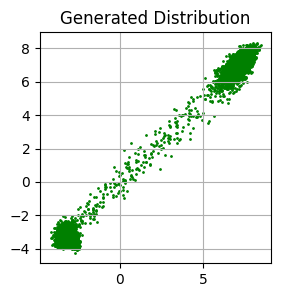

	| Save distribution image to Training_Result/logs/Epoch_265.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 242.17it/s]


Epoch[266/300] : Generator Loss = 0.1377, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 252.09it/s]


Epoch[267/300] : Generator Loss = 0.1402, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 233.75it/s]


Epoch[268/300] : Generator Loss = 0.1358, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 253.16it/s]


Epoch[269/300] : Generator Loss = 0.1358, Descriminator Loss = -0.0003


100%|██████████| 1563/1563 [00:06<00:00, 239.07it/s]


Epoch[270/300] : Generator Loss = 0.1320, Descriminator Loss = -0.0004


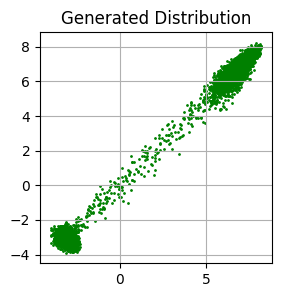

	| Save distribution image to Training_Result/logs/Epoch_270.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 262.32it/s]


Epoch[271/300] : Generator Loss = 0.1355, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 238.47it/s]


Epoch[272/300] : Generator Loss = 0.1326, Descriminator Loss = -0.0001


100%|██████████| 1563/1563 [00:06<00:00, 256.01it/s]


Epoch[273/300] : Generator Loss = 0.1289, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:06<00:00, 242.56it/s]


Epoch[274/300] : Generator Loss = 0.1356, Descriminator Loss = -0.0005


100%|██████████| 1563/1563 [00:06<00:00, 259.12it/s]


Epoch[275/300] : Generator Loss = 0.1358, Descriminator Loss = -0.0003


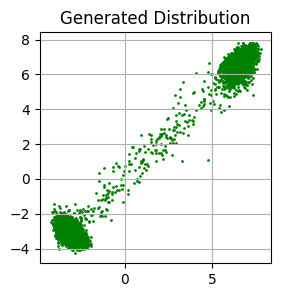

	| Save distribution image to Training_Result/logs/Epoch_275.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 239.96it/s]


Epoch[276/300] : Generator Loss = 0.1384, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:05<00:00, 262.81it/s]


Epoch[277/300] : Generator Loss = 0.1353, Descriminator Loss = -0.0005


100%|██████████| 1563/1563 [00:06<00:00, 239.32it/s]


Epoch[278/300] : Generator Loss = 0.1343, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:05<00:00, 262.45it/s]


Epoch[279/300] : Generator Loss = 0.1341, Descriminator Loss = -0.0008


100%|██████████| 1563/1563 [00:06<00:00, 242.31it/s]


Epoch[280/300] : Generator Loss = 0.1248, Descriminator Loss = -0.0003


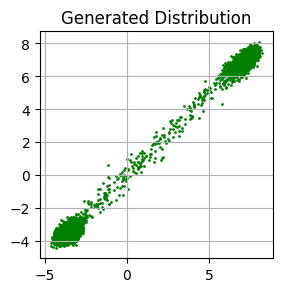

	| Save distribution image to Training_Result/logs/Epoch_280.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 263.28it/s]


Epoch[281/300] : Generator Loss = 0.1274, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 242.87it/s]


Epoch[282/300] : Generator Loss = 0.1285, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:05<00:00, 262.62it/s]


Epoch[283/300] : Generator Loss = 0.1328, Descriminator Loss = -0.0006


100%|██████████| 1563/1563 [00:06<00:00, 242.91it/s]


Epoch[284/300] : Generator Loss = 0.1297, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:05<00:00, 262.09it/s]


Epoch[285/300] : Generator Loss = 0.1370, Descriminator Loss = -0.0013


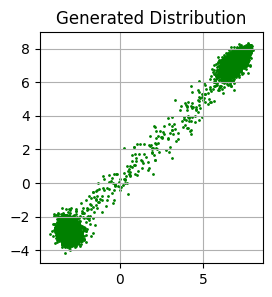

	| Save distribution image to Training_Result/logs/Epoch_285.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 239.12it/s]


Epoch[286/300] : Generator Loss = 0.1287, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:06<00:00, 258.28it/s]


Epoch[287/300] : Generator Loss = 0.1346, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:06<00:00, 244.30it/s]


Epoch[288/300] : Generator Loss = 0.1336, Descriminator Loss = -0.0011


100%|██████████| 1563/1563 [00:06<00:00, 257.21it/s]


Epoch[289/300] : Generator Loss = 0.1373, Descriminator Loss = -0.0010


100%|██████████| 1563/1563 [00:06<00:00, 245.54it/s]


Epoch[290/300] : Generator Loss = 0.1236, Descriminator Loss = -0.0003


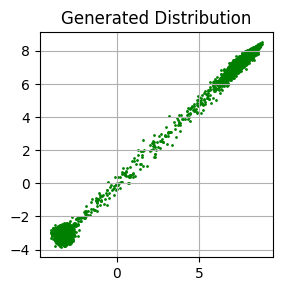

	| Save distribution image to Training_Result/logs/Epoch_290.jpg.


100%|██████████| 1563/1563 [00:06<00:00, 251.71it/s]


Epoch[291/300] : Generator Loss = 0.1260, Descriminator Loss = -0.0004


100%|██████████| 1563/1563 [00:06<00:00, 252.26it/s]


Epoch[292/300] : Generator Loss = 0.1211, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:06<00:00, 249.14it/s]


Epoch[293/300] : Generator Loss = 0.1202, Descriminator Loss = -0.0014


100%|██████████| 1563/1563 [00:06<00:00, 256.18it/s]


Epoch[294/300] : Generator Loss = 0.1167, Descriminator Loss = -0.0001


100%|██████████| 1563/1563 [00:06<00:00, 246.03it/s]


Epoch[295/300] : Generator Loss = 0.1192, Descriminator Loss = -0.0005


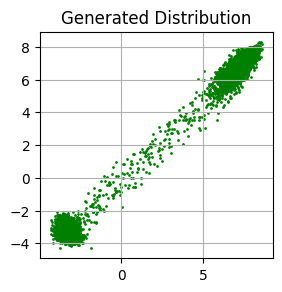

	| Save distribution image to Training_Result/logs/Epoch_295.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 263.41it/s]


Epoch[296/300] : Generator Loss = 0.1248, Descriminator Loss = -0.0012


100%|██████████| 1563/1563 [00:06<00:00, 243.96it/s]


Epoch[297/300] : Generator Loss = 0.1297, Descriminator Loss = -0.0007


100%|██████████| 1563/1563 [00:05<00:00, 264.15it/s]


Epoch[298/300] : Generator Loss = 0.1244, Descriminator Loss = -0.0005


100%|██████████| 1563/1563 [00:06<00:00, 245.76it/s]


Epoch[299/300] : Generator Loss = 0.1352, Descriminator Loss = -0.0009


100%|██████████| 1563/1563 [00:05<00:00, 261.73it/s]


Epoch[300/300] : Generator Loss = 0.1252, Descriminator Loss = -0.0004


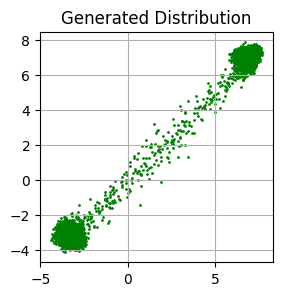

	| Save distribution image to Training_Result/logs/Epoch_300.jpg.


In [15]:
from tqdm import tqdm

# Start training and testing
# For ploting the trend image
for epoc in range(NUM_EPOCHS, 100+NUM_EPOCHS):
    train_loss_G = list()
    train_loss_D = list()
    progress_bar = tqdm(dot_dataloader)
    for i, (x, _) in enumerate(progress_bar):
        ''' train D '''
        r_point = x.to(device)
        # random noise
        z = Variable(torch.randn(x.shape[0], z_dim)).to(device)

        f_point = G(z) # output shape is (batch_size, 2)
        # prepare value for loss function
        r_label = Variable(torch.ones(x.shape[0], 1)).to(device) # real: 1
        f_label = Variable(torch.zeros(x.shape[0], 1)).to(device) # fake: 0

        # Forward D
        # r_logit = D(r_point.detach())
        # f_logit = D(f_point.detach())

        # GAN Loss
        # r_loss = criterion(r_logit, r_label)
        # f_loss = criterion(f_logit, f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(D(r_point)) + torch.mean(D(f_point))

        # Model backwarding
        opt_D.zero_grad()
        loss_D.backward()

        # Update the descriminator.
        opt_D.step()

        train_loss_D.append(loss_D.item())

        """ Clip weights of discriminator. """
        for p in D.parameters():
           p.data.clamp_(-clip_value, clip_value)

        ''' train G '''
        if i % n_critic == 0:
            # random noise
            z = Variable(torch.randn(x.shape[0], z_dim)).to(device)

            f_point = G(z) # output shape is (batch_size, 2)

            # f_logit = D(f_point)
            # GAN Loss
            # loss_G = criterion(f_logit, r_label)

            # WGAN Loss
            loss_G = -torch.mean(D(f_point))

            # Model backwarding
            opt_G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

            train_loss_G.append(loss_G.item())

    mean_loss_D = np.mean(train_loss_D)
    mean_loss_G = np.mean(train_loss_G)
    # record the training data
    total_train_loss_D.append(mean_loss_D)
    total_train_loss_G.append(mean_loss_G)
    print("Epoch[{:>2d}/{:>2d}] : Generator Loss = {:.4f}, Descriminator Loss = {:.4f}".format(epoc+1, 100+NUM_EPOCHS, mean_loss_G, mean_loss_D))

    if (epoc+1) % 5 == 0:
        G.eval()
        f_points_sample = G(z_sample)
        fig = draw_scatter(f_points_sample.cpu().detach().numpy())
        filename = os.path.join(log_dir, f'Epoch_{epoc+1:03d}.jpg')
        fig.savefig(filename, dpi=300)
        plt.show()
        plt.close(fig)
        print(f'\t| Save distribution image to {filename}.')

        G.train()
    # Save the checkpoints.
    torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))
    torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))

Generator training Process


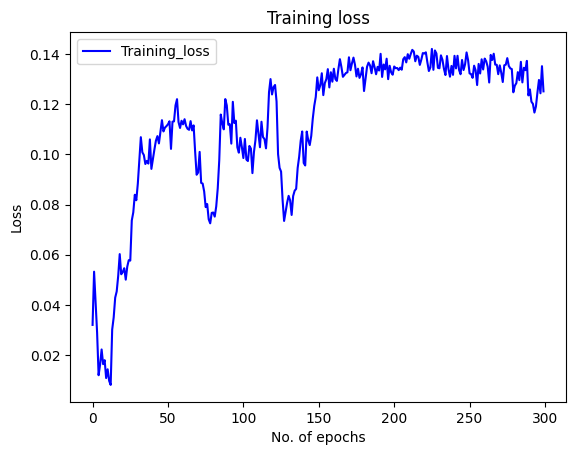

In [16]:
print("Generator training Process")
plt_loss_accuracy_fig(total_train_loss_G)

Descriminator training Process


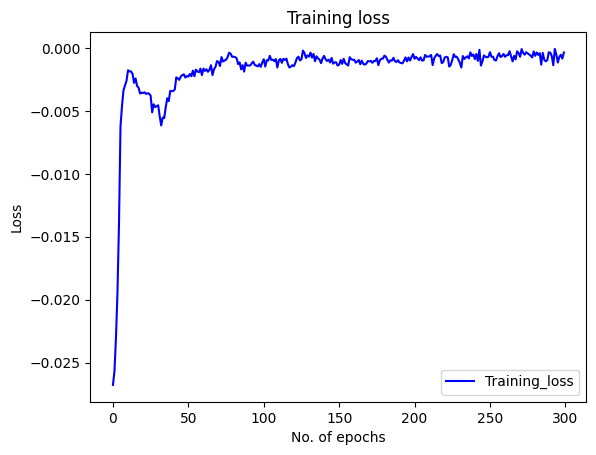

In [17]:
print("Descriminator training Process")
plt_loss_accuracy_fig(total_train_loss_D)

Generated from `z_sample` which is the same as the one tested during training.

In [18]:
def draw_scatter_mark_center(points):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot the dataset
    ax.scatter(points[:, 0], points[:, 1], c='green', s=1)
    ax.set_title('Generated Distribution')
    ax.grid(True)
    ax.set_aspect('equal')  # Equal aspect ratio for X and Y axes

    # Mark the cluster centers
    centers = np.array([[7, 7], [-3, -3]])
    ax.scatter(centers[0, 0], centers[0, 1], c='blue', s=50, marker='.', label='Ideal Centers (7,7)')
    ax.scatter(centers[1, 0], centers[1, 1], c='red', s=50, marker='.', label='Ideal Centers (-3,-3)')

    # Set axis limits
    # ax.set_xlim(-10, 10)
    # ax.set_ylim(-10, 10)

    # Add legend
    ax.legend()

    # Return the figure object for saving
    return fig


Load pth from Training_Result/checkpoints/G.pth


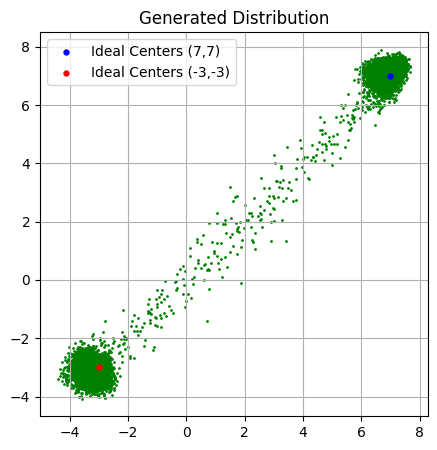

In [20]:
G = Generator(in_dim=z_dim, out_dim=2, dim=hidden_dim).to(device)
pth_path = os.path.join(ckpt_dir, 'G.pth')
state_dict = torch.load(pth_path)
G.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
G.eval()

f_points_sample = G(z_sample)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)

Generated from **new samples**.

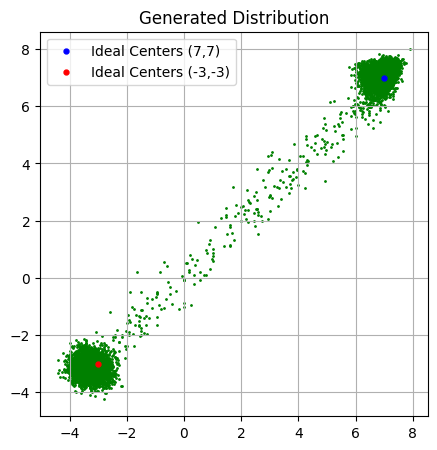

In [21]:
f_points_sample = G(Variable(torch.randn(10000, z_dim) * 1).to(device))
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)

In [22]:
!zip -r Training_Result.zip Training_Result/

  adding: Training_Result/ (stored 0%)
  adding: Training_Result/checkpoints/ (stored 0%)
  adding: Training_Result/checkpoints/D.pth (deflated 30%)
  adding: Training_Result/checkpoints/G.pth (deflated 6%)
  adding: Training_Result/logs/ (stored 0%)
  adding: Training_Result/logs/Epoch_060.jpg (deflated 34%)
  adding: Training_Result/logs/Epoch_185.jpg (deflated 38%)
  adding: Training_Result/logs/Epoch_045.jpg (deflated 37%)
  adding: Training_Result/logs/Epoch_115.jpg (deflated 34%)
  adding: Training_Result/logs/Epoch_095.jpg (deflated 35%)
  adding: Training_Result/logs/Epoch_275.jpg (deflated 37%)
  adding: Training_Result/logs/Epoch_235.jpg (deflated 40%)
  adding: Training_Result/logs/Epoch_265.jpg (deflated 39%)
  adding: Training_Result/logs/Epoch_005.jpg (deflated 30%)
  adding: Training_Result/logs/Epoch_270.jpg (deflated 44%)
  adding: Training_Result/logs/Epoch_255.jpg (deflated 38%)
  adding: Training_Result/logs/Epoch_220.jpg (deflated 40%)
  adding: Training_Result/log

#### i. Generate **50 data points** using the trained model.
#### ii. **Plot the generated points on a 2D graph** to visualize how well they match the original distribution.

Load pth from Training_Result/checkpoints/G.pth


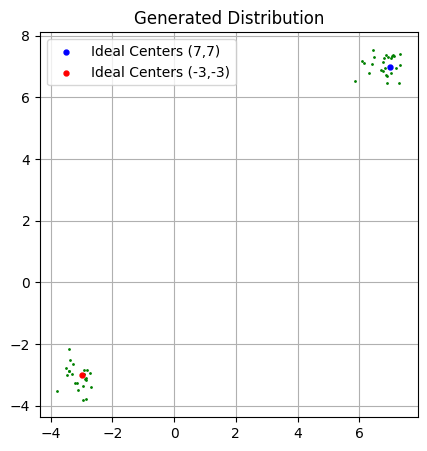

In [23]:
G = Generator(in_dim=z_dim, out_dim=2, dim=hidden_dim).to(device)
pth_path = os.path.join(ckpt_dir, 'G.pth')
state_dict = torch.load(pth_path)
G.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
G.eval()

generated_points = 50
f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device))
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)

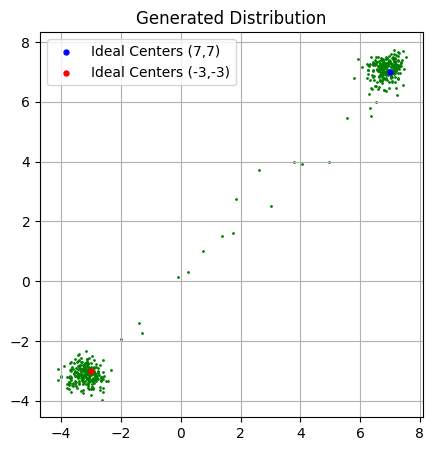

In [24]:
generated_points = 500
f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device))
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)

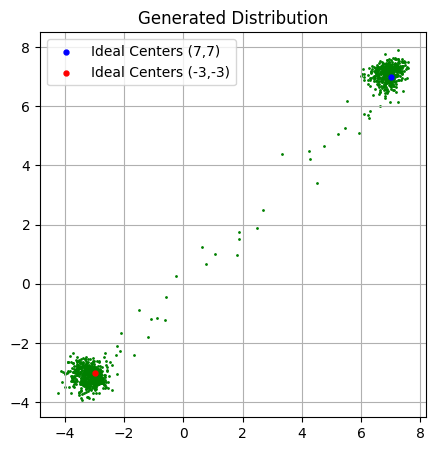

In [25]:
generated_points = 1000
f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device))
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)

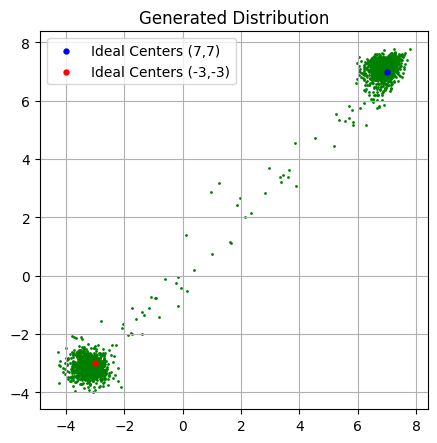

In [27]:
generated_points = 2000
f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device))
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)